In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium

file_path = "EV Data-2012-Dec-03_08-40-11.csv"
df = pd.read_excel(file_path)

def plot_trajectory_with_folium(latitudes, longitudes, title="车辆轨迹图"):
    """
    使用Folium绘制交互式车辆轨迹
    
    参数:
    latitudes: 纬度列表
    longitudes: 经度列表
    title: 地图标题
    """
    # 计算中心点
    center_lat = sum(latitudes) / len(latitudes)
    center_lon = sum(longitudes) / len(longitudes)
    
    # 创建地图
    m = folium.Map(location=[center_lat, center_lon], 
                   zoom_start=13, 
                   tiles='OpenStreetMap')
    
    # 添加轨迹线
    points = list(zip(latitudes, longitudes))
    folium.PolyLine(points, 
                    color='red', 
                    weight=5, 
                    opacity=0.8,
                    popup=title).add_to(m)
    
    # 添加起点和终点标记
    folium.Marker([latitudes[0], longitudes[0]], 
                  popup='起点',
                  icon=folium.Icon(color='green', icon='play')).add_to(m)
    
    folium.Marker([latitudes[-1], longitudes[-1]], 
                  popup='终点',
                  icon=folium.Icon(color='blue', icon='stop')).add_to(m)
    
    # 添加轨迹点标记
    for i, (lat, lon) in enumerate(points):
        if i % 5 == 0:  # 每5个点标记一次
            folium.CircleMarker([lat, lon],
                                radius=3,
                                popup=f'点 {i}',
                                color='black',
                                fill=True).add_to(m)
    
    # 保存为HTML文件
    m.save('vehicle_trajectory.html')
    print("交互式地图已保存为 'vehicle_trajectory.html'")
    
    return m



        # 提取经纬度数据
latitudes = df["Latitude"].tolist()
longitudes = df["Longitude"].tolist()
        
print(f"读取了 {len(latitudes)} 个数据点")
        
        # 绘制交互式地图
plot_trajectory_with_folium(latitudes, longitudes, "从CSV文件读取的车辆轨迹")
        

读取了 1223 个数据点
交互式地图已保存为 'vehicle_trajectory.html'


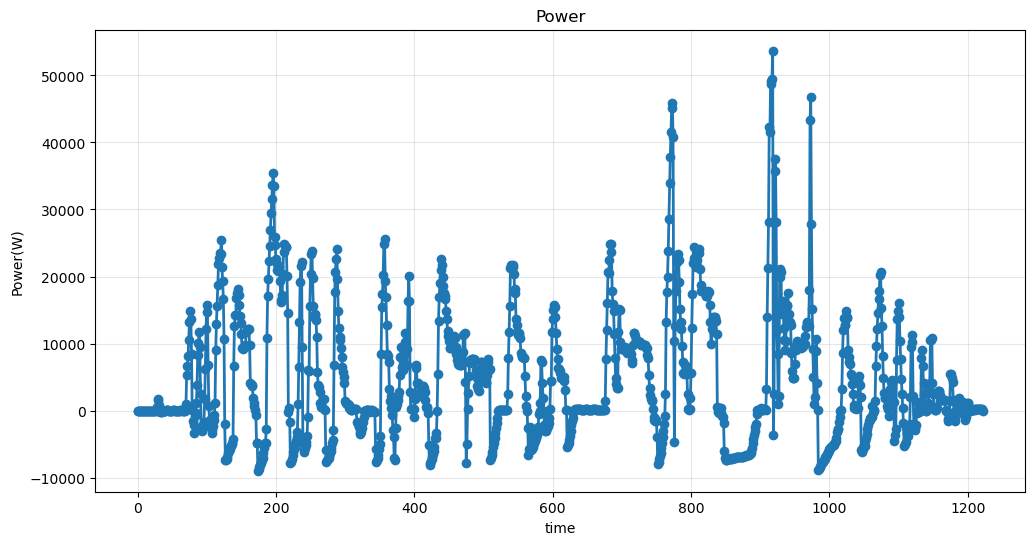

In [14]:
power = df["Pack_Power(W)"].tolist()
# 创建时间索引（假设是等间隔时间）
time = range(len(power))

plt.figure(figsize=(12, 6))
plt.plot(time, power, marker='o', linewidth=2, markersize=6)
plt.xlabel('time')
plt.ylabel('Power(W)')
plt.title('Power')
plt.grid(True, alpha=0.3)
plt.show()

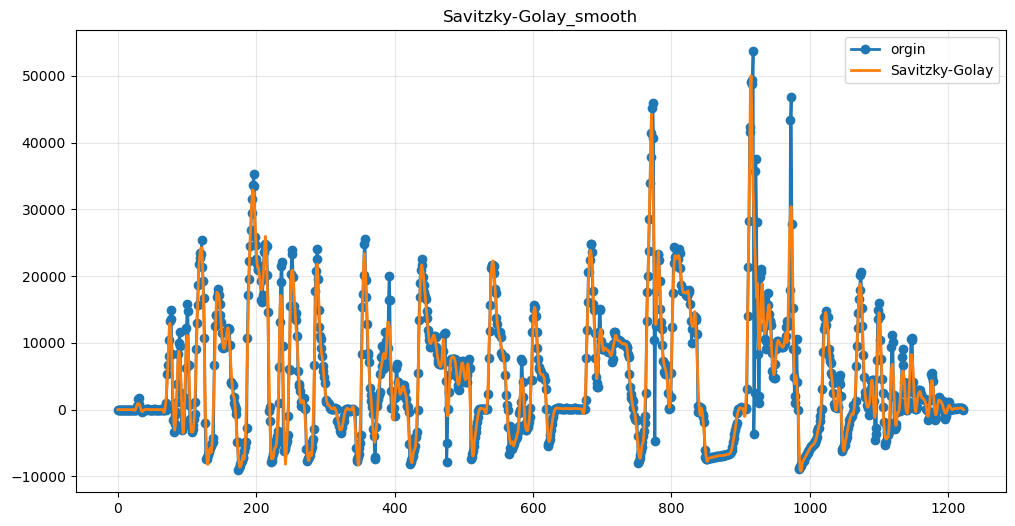

In [15]:
from scipy.signal import savgol_filter

# Savitzky-Golay 滤波器（保留特征的同时平滑）
window_length = 11  # 窗口长度（必须为奇数）
polyorder = 3       # 多项式阶数

power_sg = savgol_filter(power, window_length, polyorder)

plt.figure(figsize=(12, 6))
plt.plot(time, power, marker='o', label='orgin',linewidth=2, markersize=6)
plt.plot(time,power_sg, label='Savitzky-Golay', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Savitzky-Golay_smooth')
plt.show()

In [16]:
from scipy import integrate
# 辛普森法数值积分
def simpson_integration(time, power_values):
    """使用辛普森法计算积分"""
    return integrate.simpson(power_values, time)

simpson_integral = simpson_integration(time, power_sg)
print(f"平滑后总积分 (辛普森法): {simpson_integral:.2f} 焦耳")

平滑后总积分 (辛普森法): 5963390.24 焦耳


In [17]:
import math
r=0.11
R=0.50
f=0.006
k=1.30
m=900
g=9.8
K=10.08
a= df["Acceleration"].tolist()
grade= df["Grade"].tolist()
v= df["GPS_Speed_(Meters/second)"].tolist()
 # 将坡度百分比转换为弧度
theta=[]
for i in range(len(grade)):
    theta.append(math.atan(grade[i]/100))
    
P_forc=[]
for i in range(len(time)):
    a1=r*R*R/(K*K)
    a2=(m*a[i]+k*v[i]*v[i]+f*m*g+m*g*math.sin(theta[i]))
    P_forc.append(a1*a2*a2 +  m*a[i]*v[i] + v[i]*(k*v[i]*v[i]+ f * m * g + m * g * math.sin(theta[i])))

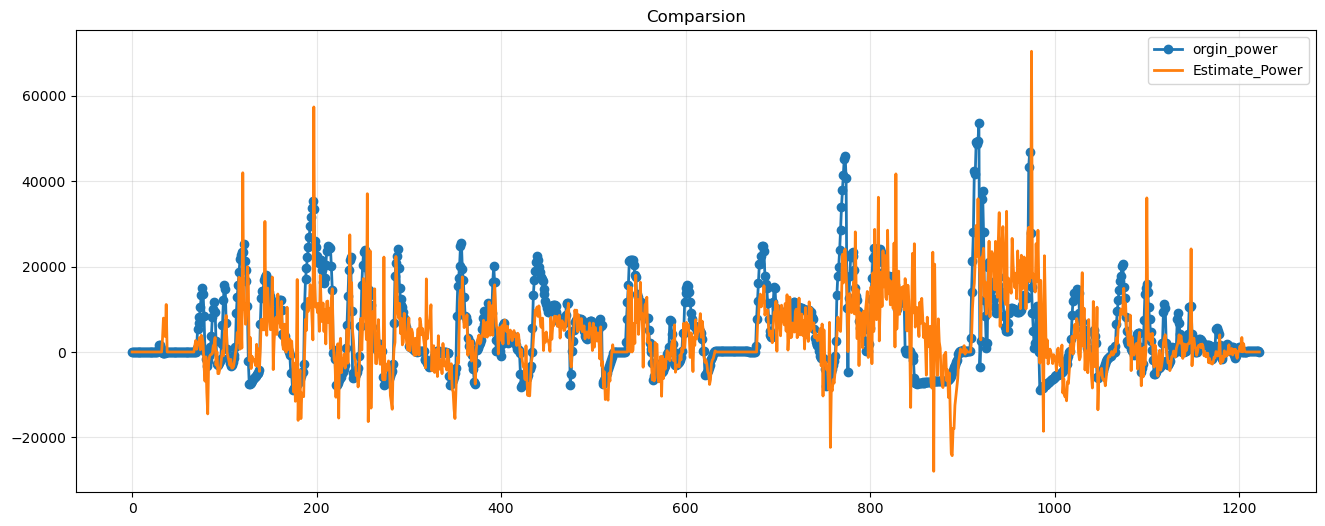

In [18]:
from scipy.signal import savgol_filter

# Savitzky-Golay 滤波器（保留特征的同时平滑）
window_length = 11  # 窗口长度（必须为奇数）
polyorder = 3       # 多项式阶数

power_sg = savgol_filter(power, window_length, polyorder)

plt.figure(figsize=(16, 6))
plt.plot(time, power, marker='o', label='orgin_power',linewidth=2, markersize=6)
plt.plot(time,P_forc, label='Estimate_Power', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Comparsion')
plt.show()

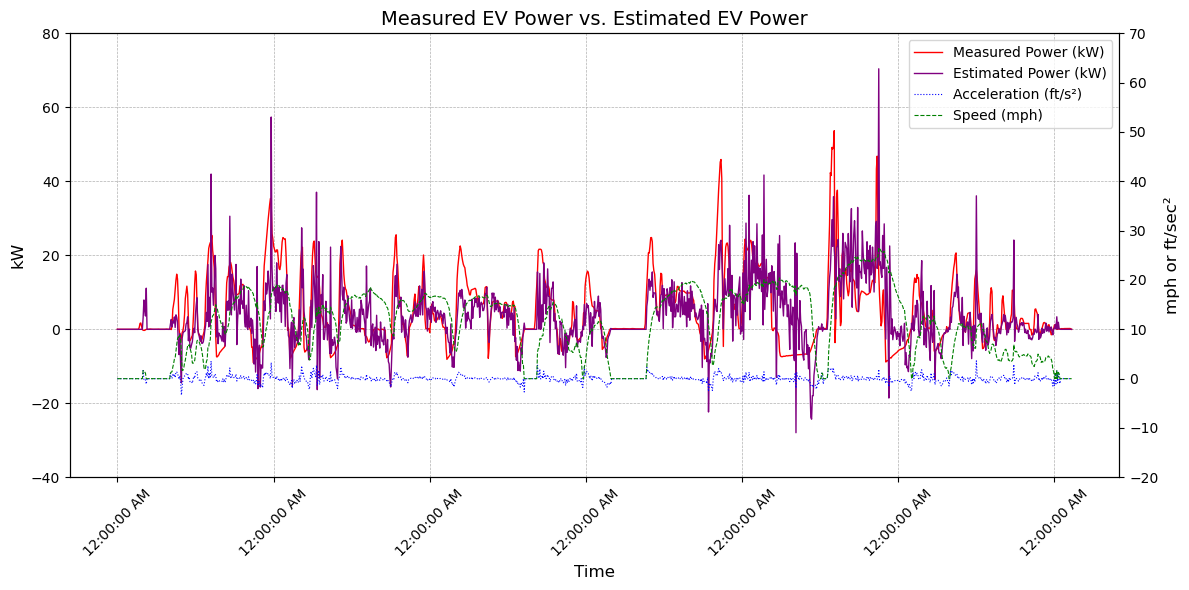

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 创建画布和轴
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in range(len(time)):
    power[i]=power[i]/1000
    P_forc[i]=P_forc[i]/1000

# 绘制 Measured Power 和 Estimated Power
ax1.plot(time, power, label="Measured Power (kW)", color="red", linewidth=1)
ax1.plot(time, P_forc, label="Estimated Power (kW)", color="purple", linewidth=1)

# 设置左侧y轴标签和范围
ax1.set_ylabel("kW", fontsize=12)
ax1.set_ylim(-40, 80)
ax1.set_xlabel("Time", fontsize=12)

# 格式化时间轴
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M:%S %p"))
plt.xticks(rotation=45)

# 创建第二个y轴，用于加速度和速度
ax2 = ax1.twinx()
ax2.plot(time, a, label="Acceleration (ft/s²)", color="blue", linewidth=0.8, linestyle="dotted")
ax2.plot(time, v, label="Speed (mph)", color="green", linewidth=0.8, linestyle="dashed")

# 设置右侧y轴标签和范围
ax2.set_ylabel("mph or ft/sec²", fontsize=12)
ax2.set_ylim(-20, 70)

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=10)

# 设置标题
plt.title("Measured EV Power vs. Estimated EV Power", fontsize=14)

# 显示网格
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# 显示图像
plt.tight_layout()
plt.show()

In [ ]:
for 